# Lab 3: House Price Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from  matplotlib.ticker import EngFormatter
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder



sns.set_theme()

Load Housing dataset.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/tiwari91/Housing-Prices/master/train.csv")

## Problem 1: Analysis of Numeric Variables

In [3]:
num_features = ["LotArea", "GrLivArea", "TotalBsmtSF", "GarageArea"]
target = "SalePrice"

<Axes: >

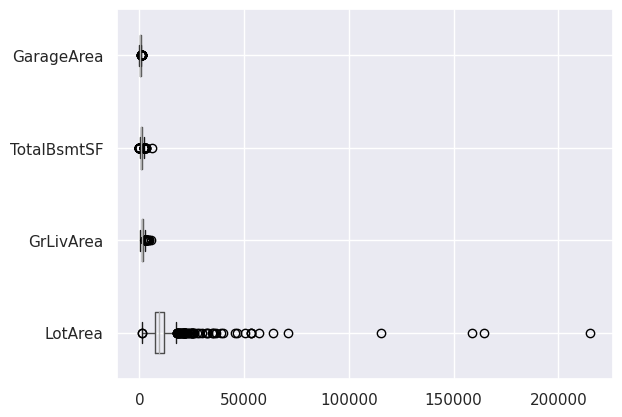

In [4]:
df[num_features].boxplot(vert=False)

- a) `LotArea` appears to have maximum number of outliers from observing the box plots

array([[<Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': 'GarageArea'}>]], dtype=object)

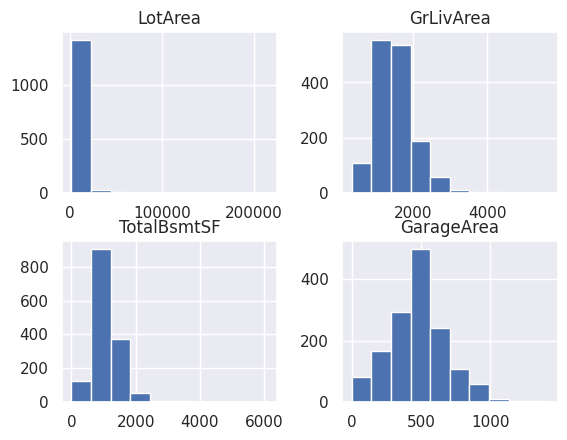

In [5]:
df[num_features].hist()

In [6]:
df[num_features].skew()

LotArea        12.207688
GrLivArea       1.366560
TotalBsmtSF     1.524255
GarageArea      0.179981
dtype: float64

- b) `LotArea` is the most skewed among the other variables. It is skewed in the **positive** direction.

In [7]:
df[num_features].corrwith(df[target]).sort_values(ascending=False)

GrLivArea      0.708624
GarageArea     0.623431
TotalBsmtSF    0.613581
LotArea        0.263843
dtype: float64

- c) `GrLivArea` and `GarageArea` are most highly correlated with our target `SalesPrice` and are therefore most numeric predictors `SalesPrice` target.

## Problem 2 : Analysis of Categorical Variables

In [8]:
cat_features = ['MSSubClass', 'Neighborhood', 'BldgType', 'OverallQual']

In [9]:
df[cat_features].nunique()

MSSubClass      15
Neighborhood    25
BldgType         5
OverallQual     10
dtype: int64

- a) `Neighborhood` has the highest no. of levels.

In [10]:
counts_dfs = []
for c, counts_df in ((c, df[c].value_counts(ascending=False).reset_index()) for c in cat_features):
  counts_df["column"] = c
  counts_dfs.append(
      counts_df.rename(columns={
        c: "count",
        "index": "level",
      })
  )
count_df = pd.concat(counts_dfs)
count_df[count_df["count"] == count_df["count"].max()]

,level,count,column
0,1Fam,1220,BldgType


- a) `1Fam` Level in `BldgType` column has the highest number of houses.

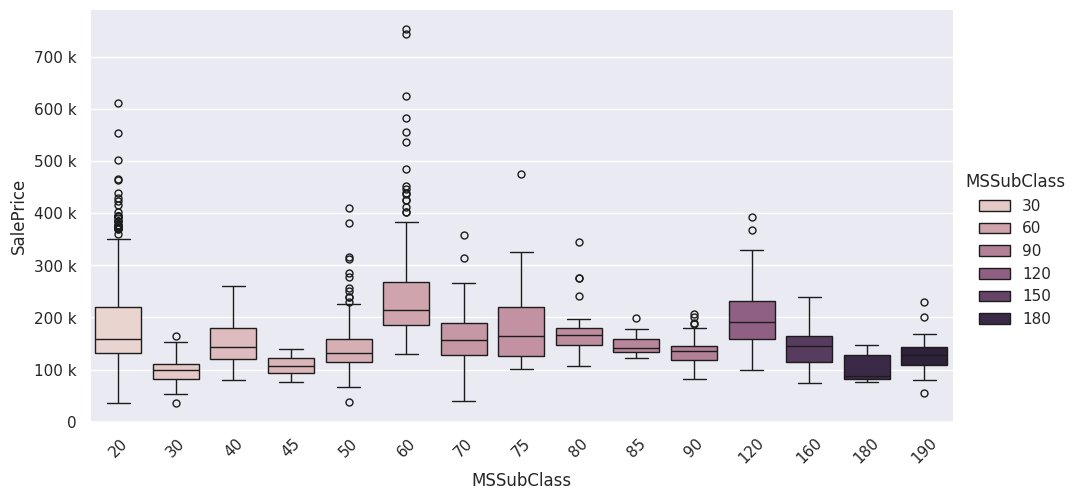

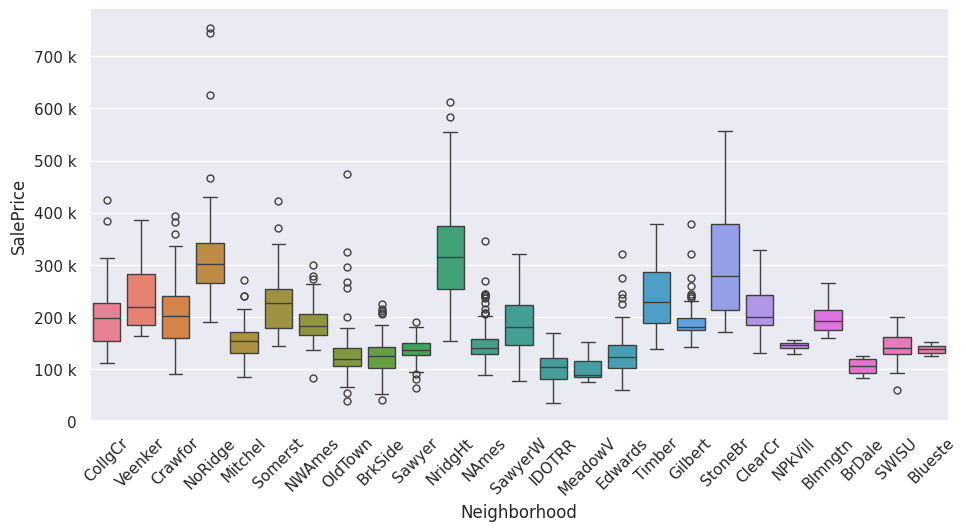

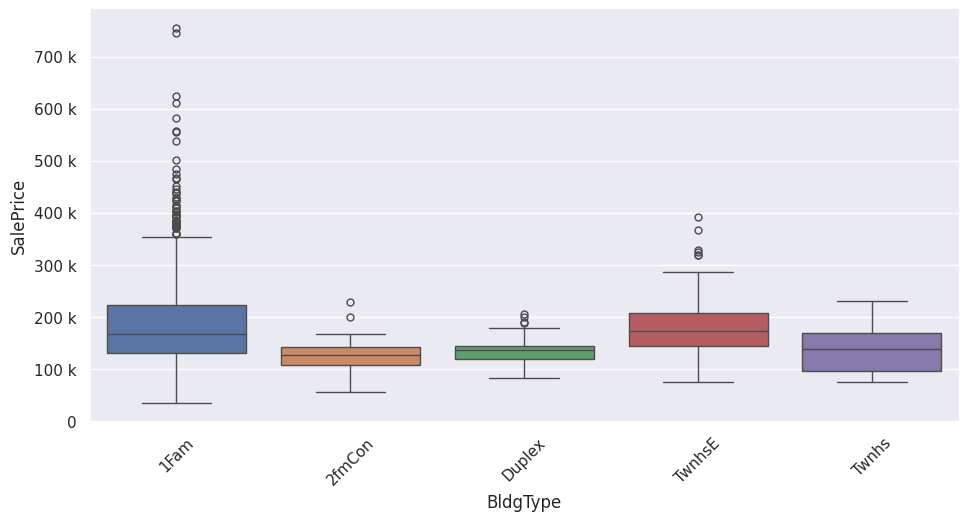

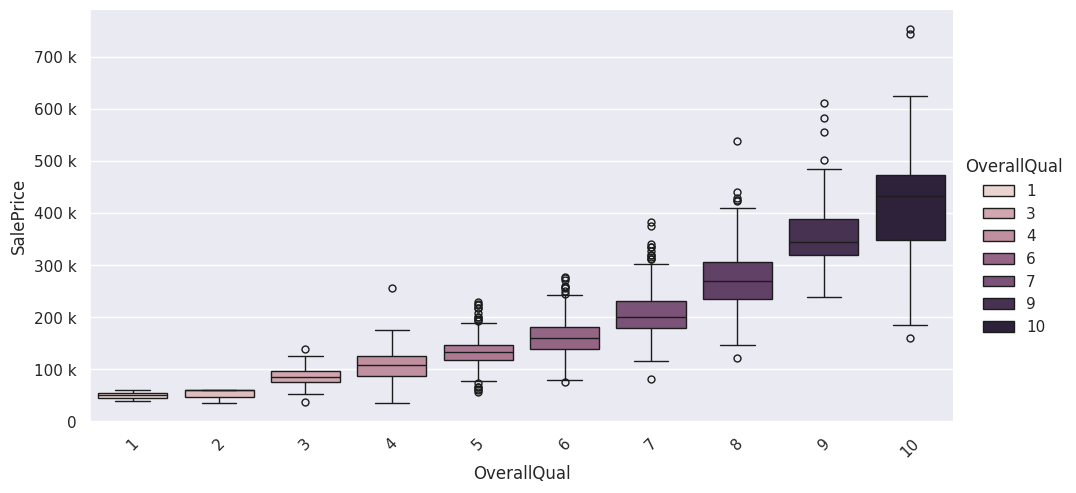

In [11]:
for c in cat_features:
  g = sns.catplot(df, hue=c, x=c, y="SalePrice", kind="box", aspect=2)
  g.ax.yaxis.set_major_formatter(EngFormatter())
  g.ax.tick_params(axis="x", labelrotation=45)

Observations:
- `OverallQuall` is an ordinal categorical variable. Its ordinal trend is positively correlated to `SalePrice`, making it potentially good predictor of the latter.
- `Neighborhood` has many levels at different price points. Given a level from
`Neighborhood` the model will have more information to making it a good predictor of the latter.

In [19]:
# encode categorical features
ordinal = "OverallQual"
encoder =  ColumnTransformer(
  [
    ("ordinal", OrdinalEncoder(), [ordinal]),
    ("one_hot", OneHotEncoder(), [c for c in cat_features if c != ordinal]),
  ]
)
encoding = encoder.fit_transform(df[cat_features])

# compute mutual information of encoded features with target for feature selection
mi_df = pd.DataFrame(
  mutual_info_regression(
    encoding, df[target],
    discrete_features=True,
    random_state=0,
  ),
  columns=["mutual_info"],
  index=encoder.get_feature_names_out()
).reset_index()

# determine top 2 features based on mutual importance
mi_df["feature"] = mi_df["index"].str.replace(
    r"[\w_]+__([^_]+)(_\w+)?", lambda m: m.group(1),
    regex=True,
)
mi_df.groupby("feature")["mutual_info"].sum().sort_values(
    ascending=False,
)[:2]

feature
OverallQual     0.571435
Neighborhood    0.567061
Name: mutual_info, dtype: float64

- b) Mutual Information feature importance analysis supports our hypothesis. Thus, based on the evidence presented, I posit that `OverallQual` & `Neighborhood` are top two categorical predictors for `SalesPrice`.

## Problem 3 : Interesting Questions for EDA

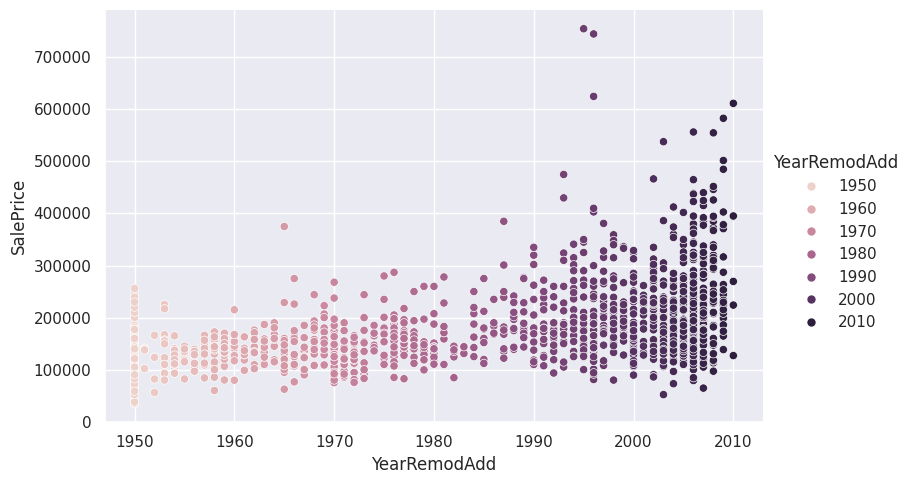

In [17]:
sns.relplot(df, y=target, x="YearRemodAdd", hue="YearRemodAdd", aspect=1.6)

- b) Yes. `SalesPrice` is affected by how recently the house is remodeled (`YearRemodAdd`). Generally, the more recently the remodeled , the higher the `SalePrice`